# Data Visualisation for Report 1

In [21]:
#import necessary libraries
import numpy as np
import pandas as pd
from scipy.io import loadmat

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# Plotting style
sns.set_style('darkgrid')
sns.set_theme(font_scale=1.)

In [22]:
#retrieve data from web source and inspect
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data'
attr_url = 'https://raw.githubusercontent.com/joshinsky/machine_learning_group35/refs/heads/main/Attribute%20descriptions.txt'

attribute_names = pd.read_csv(attr_url, sep='\t', header=None, usecols=[0])[0].tolist()

df = pd.read_csv(url, header=None, names=attribute_names)

print(df.head())
print(df.shape)

#i modified this so that it downloads both files-ákos


   id      age   gender  education  country  ethnicity   nscore   escore  \
0   1  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545   
1   2 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886   
2   3  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523   
3   4 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615   
4   5  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340   

    oscore   ascore  ...  ecstasy  heroin  ketamine legalh  lsd meth  \
0 -0.58331 -0.91699  ...      CL0     CL0       CL0    CL0  CL0  CL0   
1  1.43533  0.76096  ...      CL4     CL0       CL2    CL0  CL2  CL3   
2 -0.84732 -1.62090  ...      CL0     CL0       CL0    CL0  CL0  CL0   
3 -0.01928  0.59042  ...      CL0     CL0       CL2    CL0  CL0  CL0   
4 -0.45174 -0.30172  ...      CL1     CL0       CL0    CL1  CL0  CL0   

  mushrooms nicotine semer  vsa  
0       CL0      CL2   CL0  CL0  
1       CL0      CL4   CL0  CL0  
2       

In [23]:
# define X and y, leave only cannabis and LSD for y
X = df.iloc[:,1:13]
y = df.iloc[:,[18,20]]

# binarize y
y = y.map(lambda x: 0 if x in ['CL0', 'CL1', 'CL2'] else 1)

# 

print(X.columns)
print(X.head())
print(y.columns)
print(y.head())

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'nscore',
       'escore', 'oscore', 'ascore', 'cscore', 'impuslive', 'ss'],
      dtype='object')
       age   gender  education  country  ethnicity   nscore   escore   oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    ascore   cscore  impuslive       ss  
0 -0.91699 -0.00665   -0.21712 -1.18084  
1  0.76096 -0.14277   -0.71126 -0.21575  
2 -1.62090 -1.01450   -1.37983  0.40148  
3  0.59042  0.58489   -1.37983 -1.18084  
4 -0.30172  1.30612   -0.21712 -0.21575  
Index(['cannabis', 'coke'], dtype='object')
   cannabis  coke
0         0     0
1         1     1
2  

In [24]:
#making stupid numbers into one hot encoding
# Mapping dictionaries
age_map = {
    -0.95197: "18-24",
    -0.07854: "25-34",
     0.49788: "35-44",
     1.09449: "45-54",
     1.82213: "55-64",
     2.59171: "65+"
}

gender_map = {
     0.48246: "Female",
    -0.48246: "Male"
}

education_map = {
    -2.43591: "Left<16",
    -1.73790: "Left16",
    -1.43719: "Left17",
    -1.22751: "Left18",
    -0.61113: "SomeCollege",
    -0.05921: "ProfCert",
     0.45468: "UniDegree",
     1.16365: "Masters",
     1.98437: "Doctorate"
}

country_map = {
    -0.09765: "Australia",
     0.24923: "Canada",
    -0.46841: "NewZealand",
    -0.28519: "Other",
     0.21128: "Ireland",
     0.96082: "UK",
    -0.57009: "USA"
}

ethnicity_map = {
    -0.50212: "Asian",
    -1.10702: "Black",
     1.90725: "MixedBlackAsian",
     0.12600: "MixedWhiteAsian",
    -0.22166: "MixedWhiteBlack",
     0.11440: "Other",
    -0.31685: "White"
}

# Map codes → labels
X["age"] = X["age"].map(age_map)
X["gender"] = X["gender"].map(gender_map)
X["education"] = X["education"].map(education_map)
X["country"] = X["country"].map(country_map)
X["ethnicity"] = X["ethnicity"].map(ethnicity_map)

# One-hot encode → now column names use meanings
X_encoded = pd.get_dummies(X, columns=["age", "gender", "education", "country", "ethnicity"])

print(X_encoded.filter(like="age").head())  # example: see only age columns


   age_18-24  age_25-34  age_35-44  age_45-54  age_55-64  age_65+
0      False      False       True      False      False    False
1      False       True      False      False      False    False
2      False      False       True      False      False    False
3       True      False      False      False      False    False
4      False      False       True      False      False    False


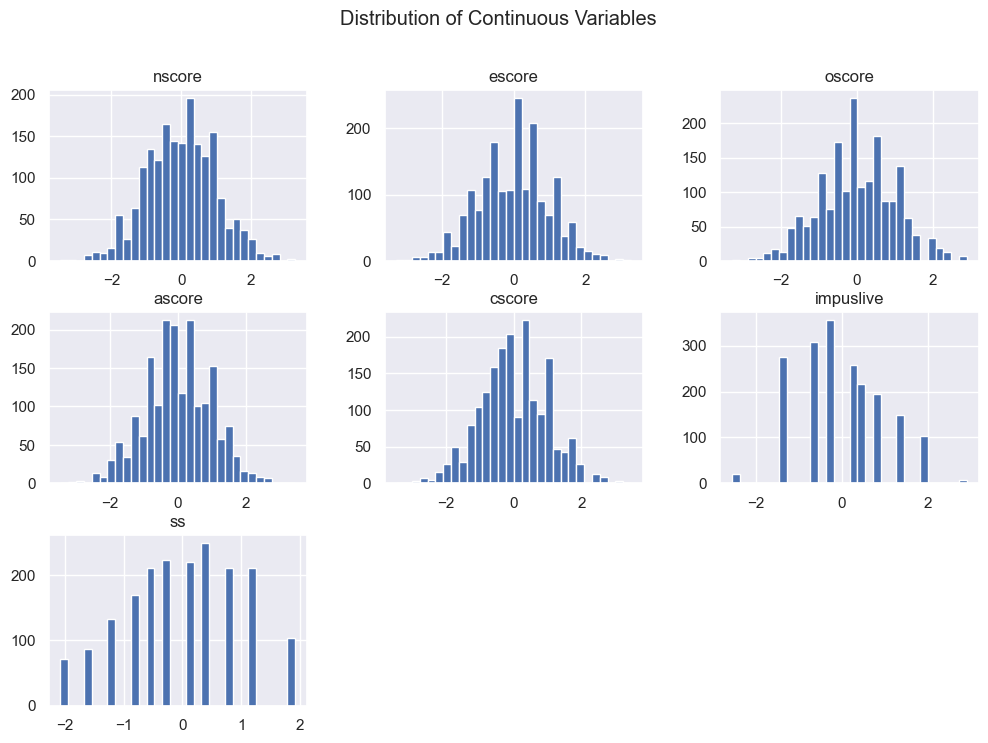

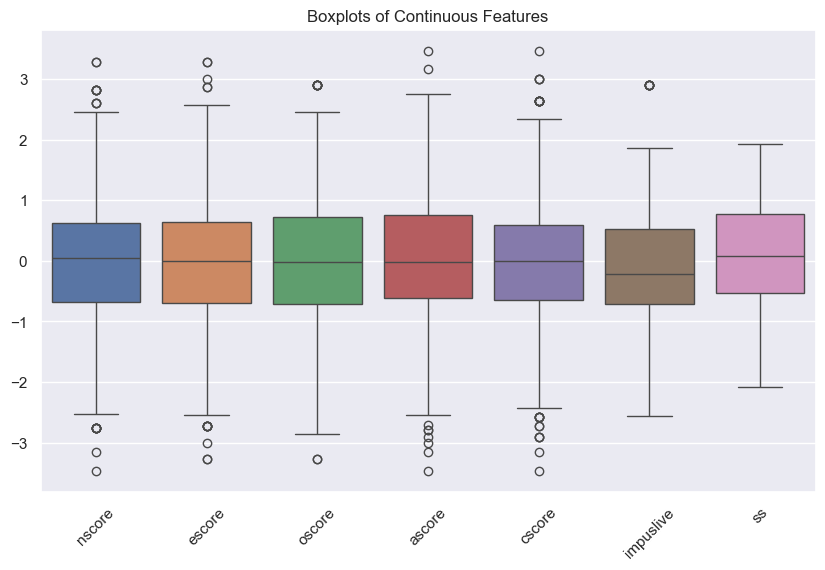

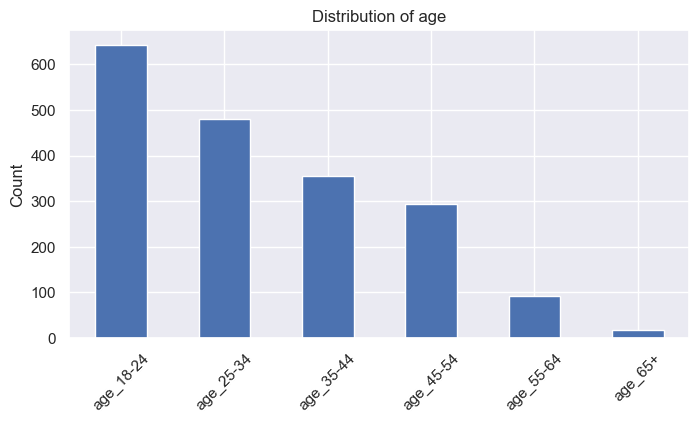

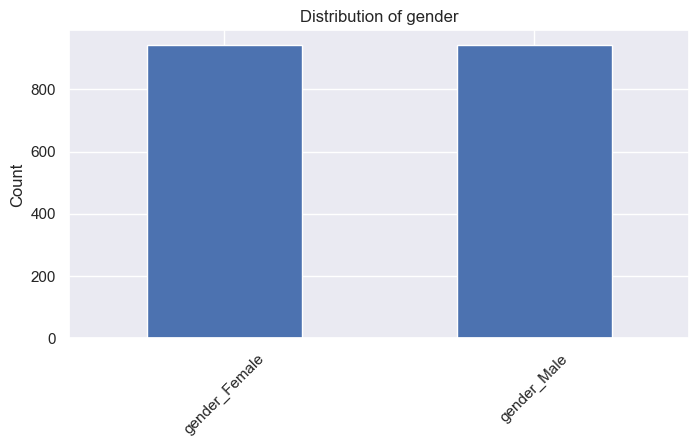

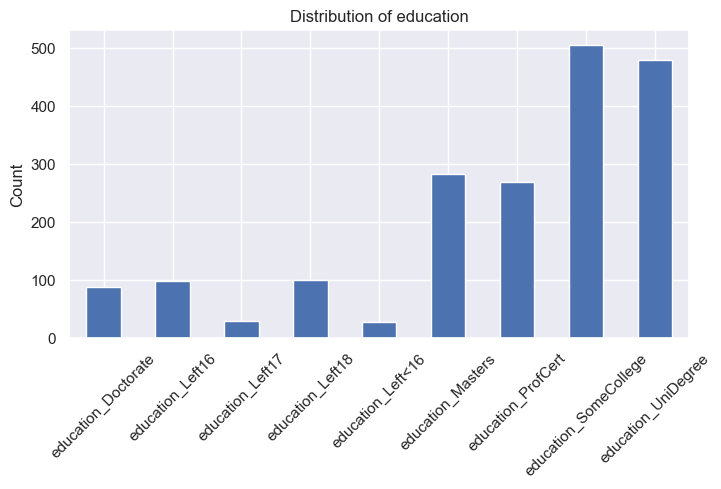

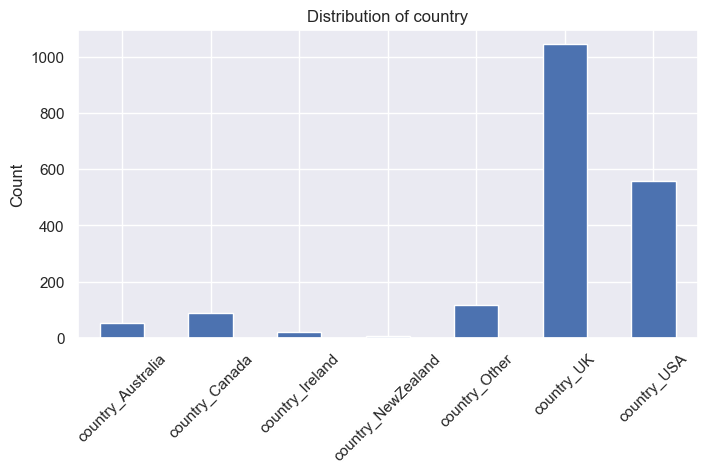

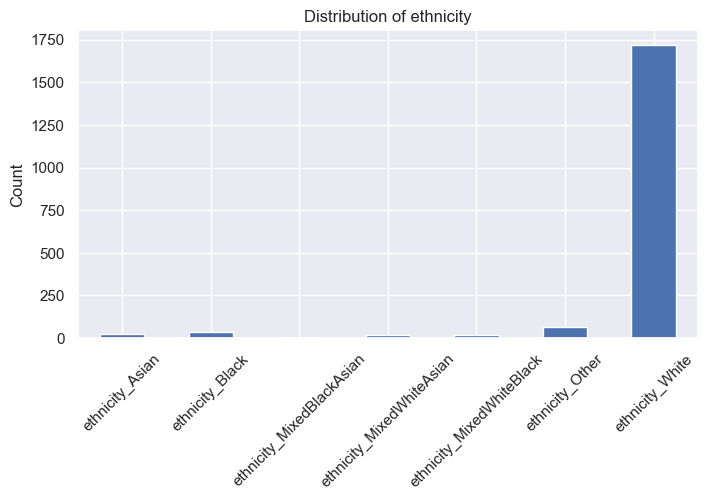

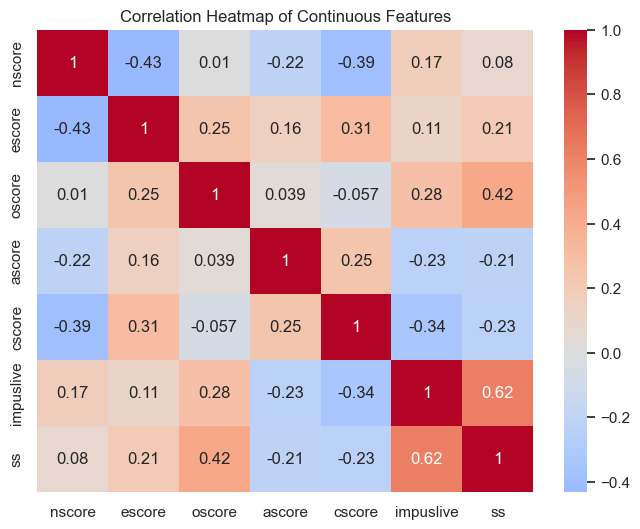

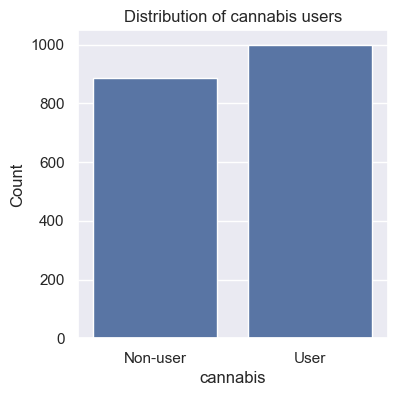

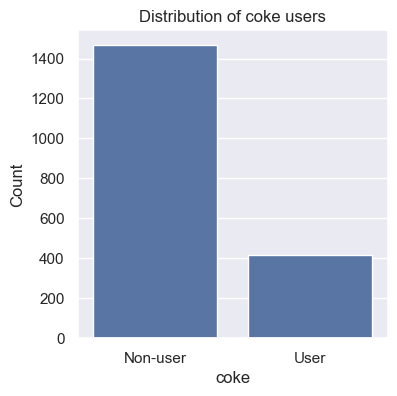

In [25]:
#Visualisations of basic data

# Continuous features (Big Five + impulsivity, ss)
cont_features = ["nscore", "escore", "oscore", "ascore", "cscore", "impuslive", "ss"]

# -----------------------------
# 1. Distribution of continuous features
# -----------------------------
X_encoded[cont_features].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribution of Continuous Variables")
plt.show()

# Boxplots for continuous features
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_encoded[cont_features])
plt.title("Boxplots of Continuous Features")
plt.xticks(rotation=45)
plt.show()

# -----------------------------
# 2. Distribution of categorical features (from one-hot dummies)
# -----------------------------
cat_prefixes = ["age_", "gender_", "education_", "country_", "ethnicity_"]

for prefix in cat_prefixes:
    plt.figure(figsize=(8, 4))
    X_encoded.filter(like=prefix).sum().plot(kind="bar")
    plt.title(f"Distribution of {prefix[:-1]}")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()

# -----------------------------
# 3. Correlation heatmap (continuous vars)
# -----------------------------
cont_features = ["nscore", "escore", "oscore", "ascore", "cscore", "impuslive", "ss"]

plt.figure(figsize=(8, 6))
sns.heatmap(X_encoded[cont_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Continuous Features")
plt.show()

# -----------------------------
# 4. Target distribution (y)
# -----------------------------
for target in y.columns:
    plt.figure(figsize=(4, 4))
    sns.countplot(x=y[target])
    plt.title(f"Distribution of {target} users")
    plt.xticks([0, 1], ["Non-user", "User"])
    plt.ylabel("Count")
    plt.show()

In [ ]:
#PCA
def run_pca_and_plot(X, y, target_col, label_name):
    features_big5 = ["nscore", "escore", "oscore", "ascore", "cscore"]
    X_pca = X[features_big5]

    pca = PCA()
    scores = pca.fit_transform(X_pca)

    scores_df = pd.DataFrame({
        "PC1": scores[:, 0],
        "PC2": scores[:, 1], 
        "PC3": scores[:, 2],
        "PC4": scores[:, 3],
        "target": y[target_col].values if hasattr(y, 'columns') else y.values
    })

    return pca, scores_df

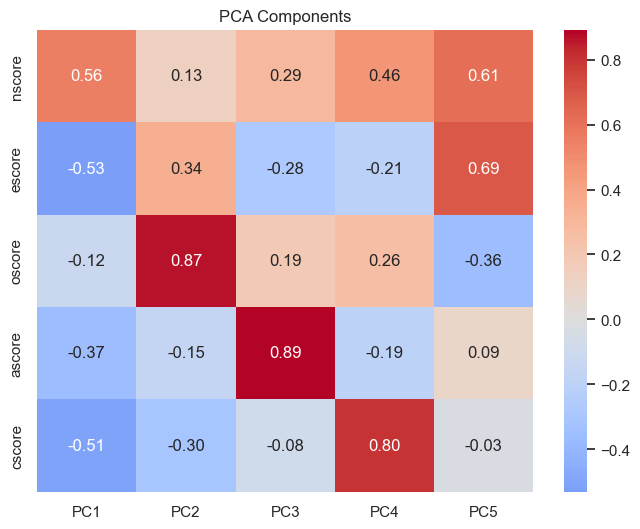

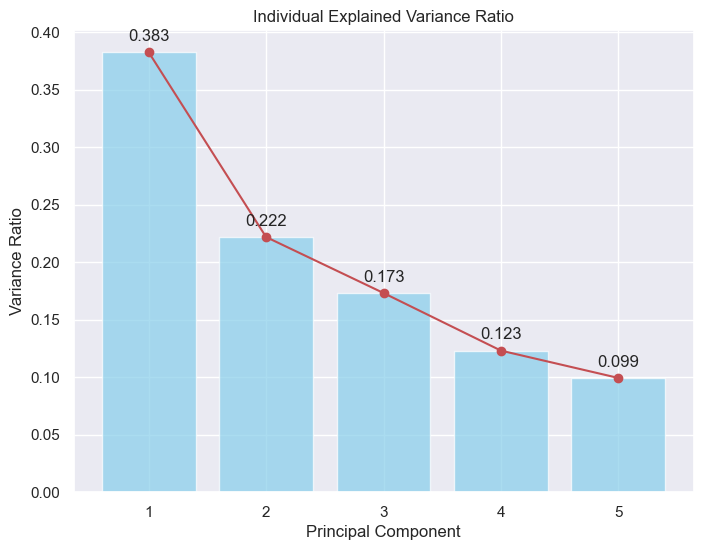

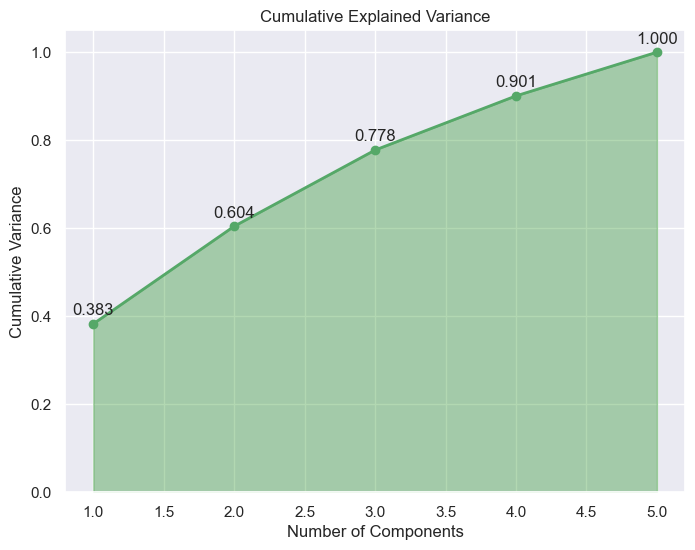

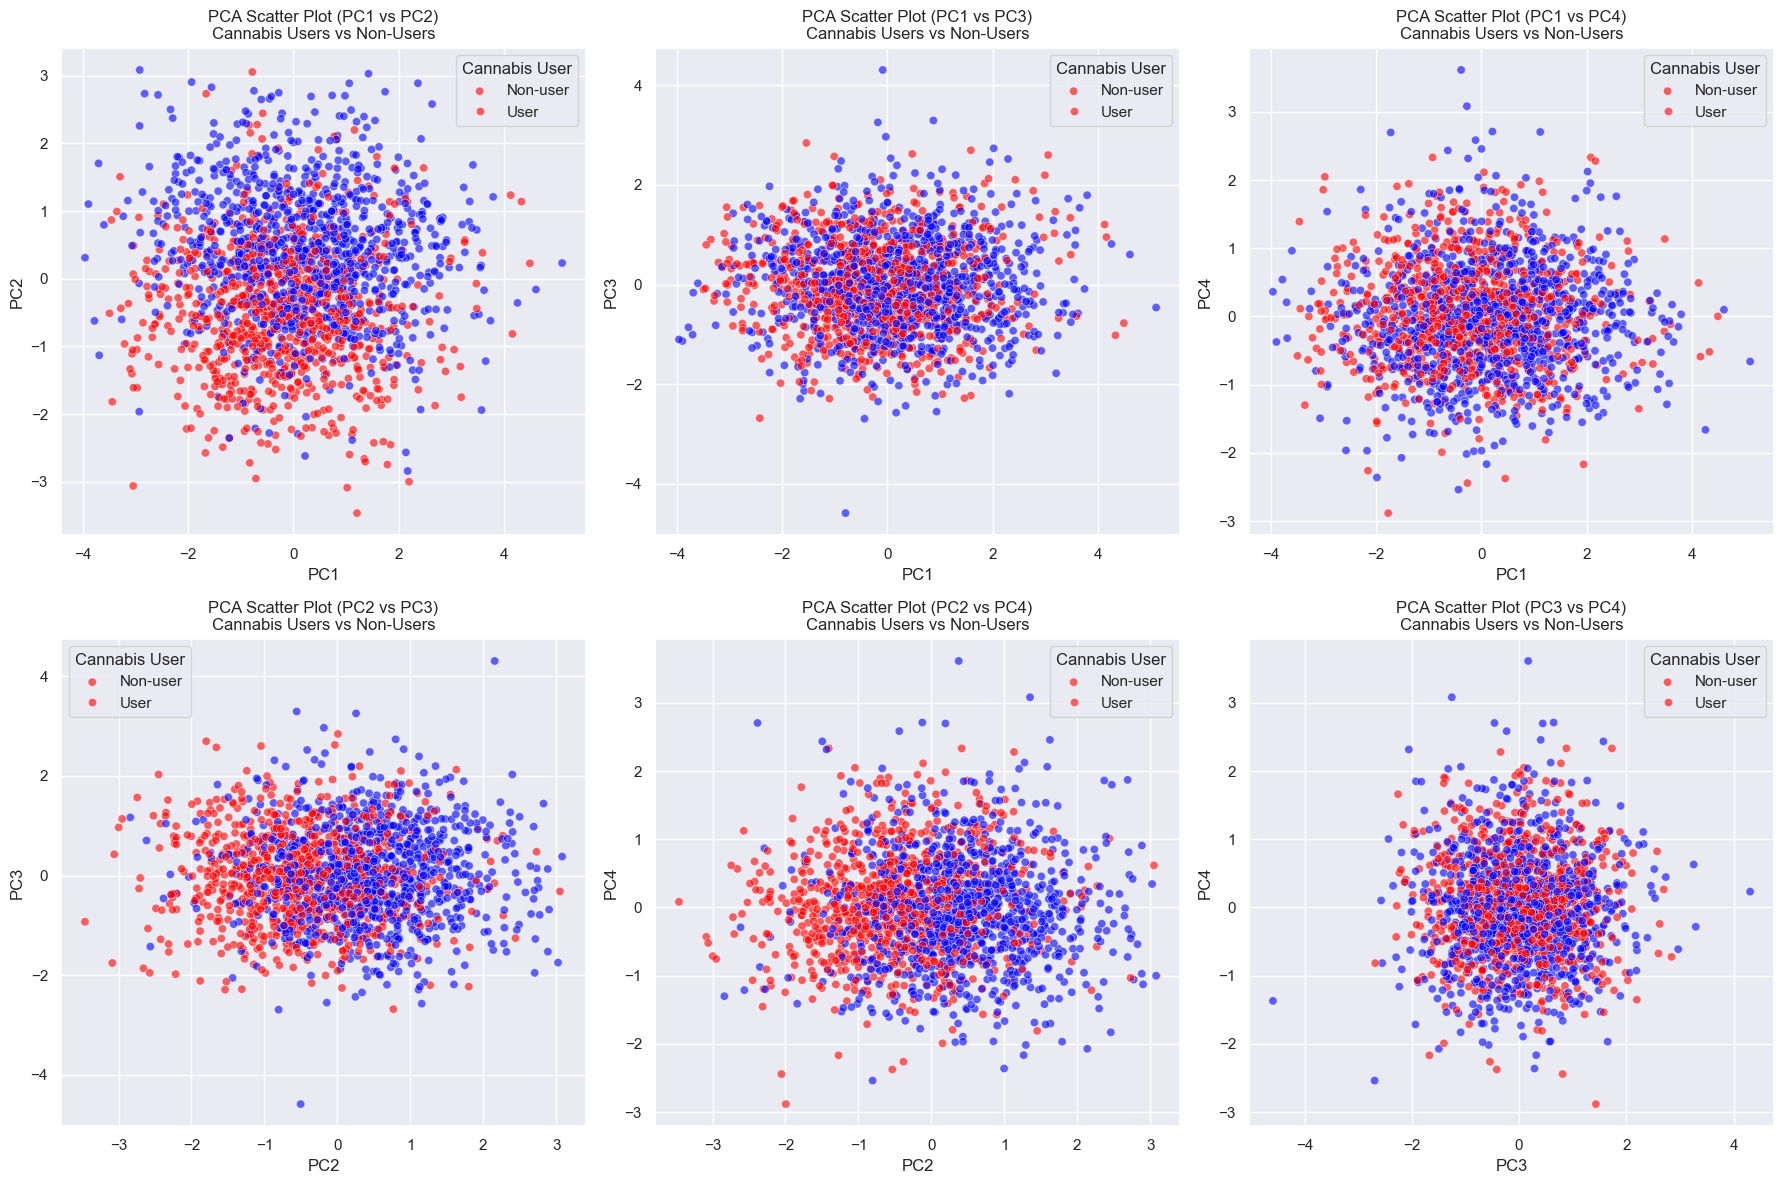

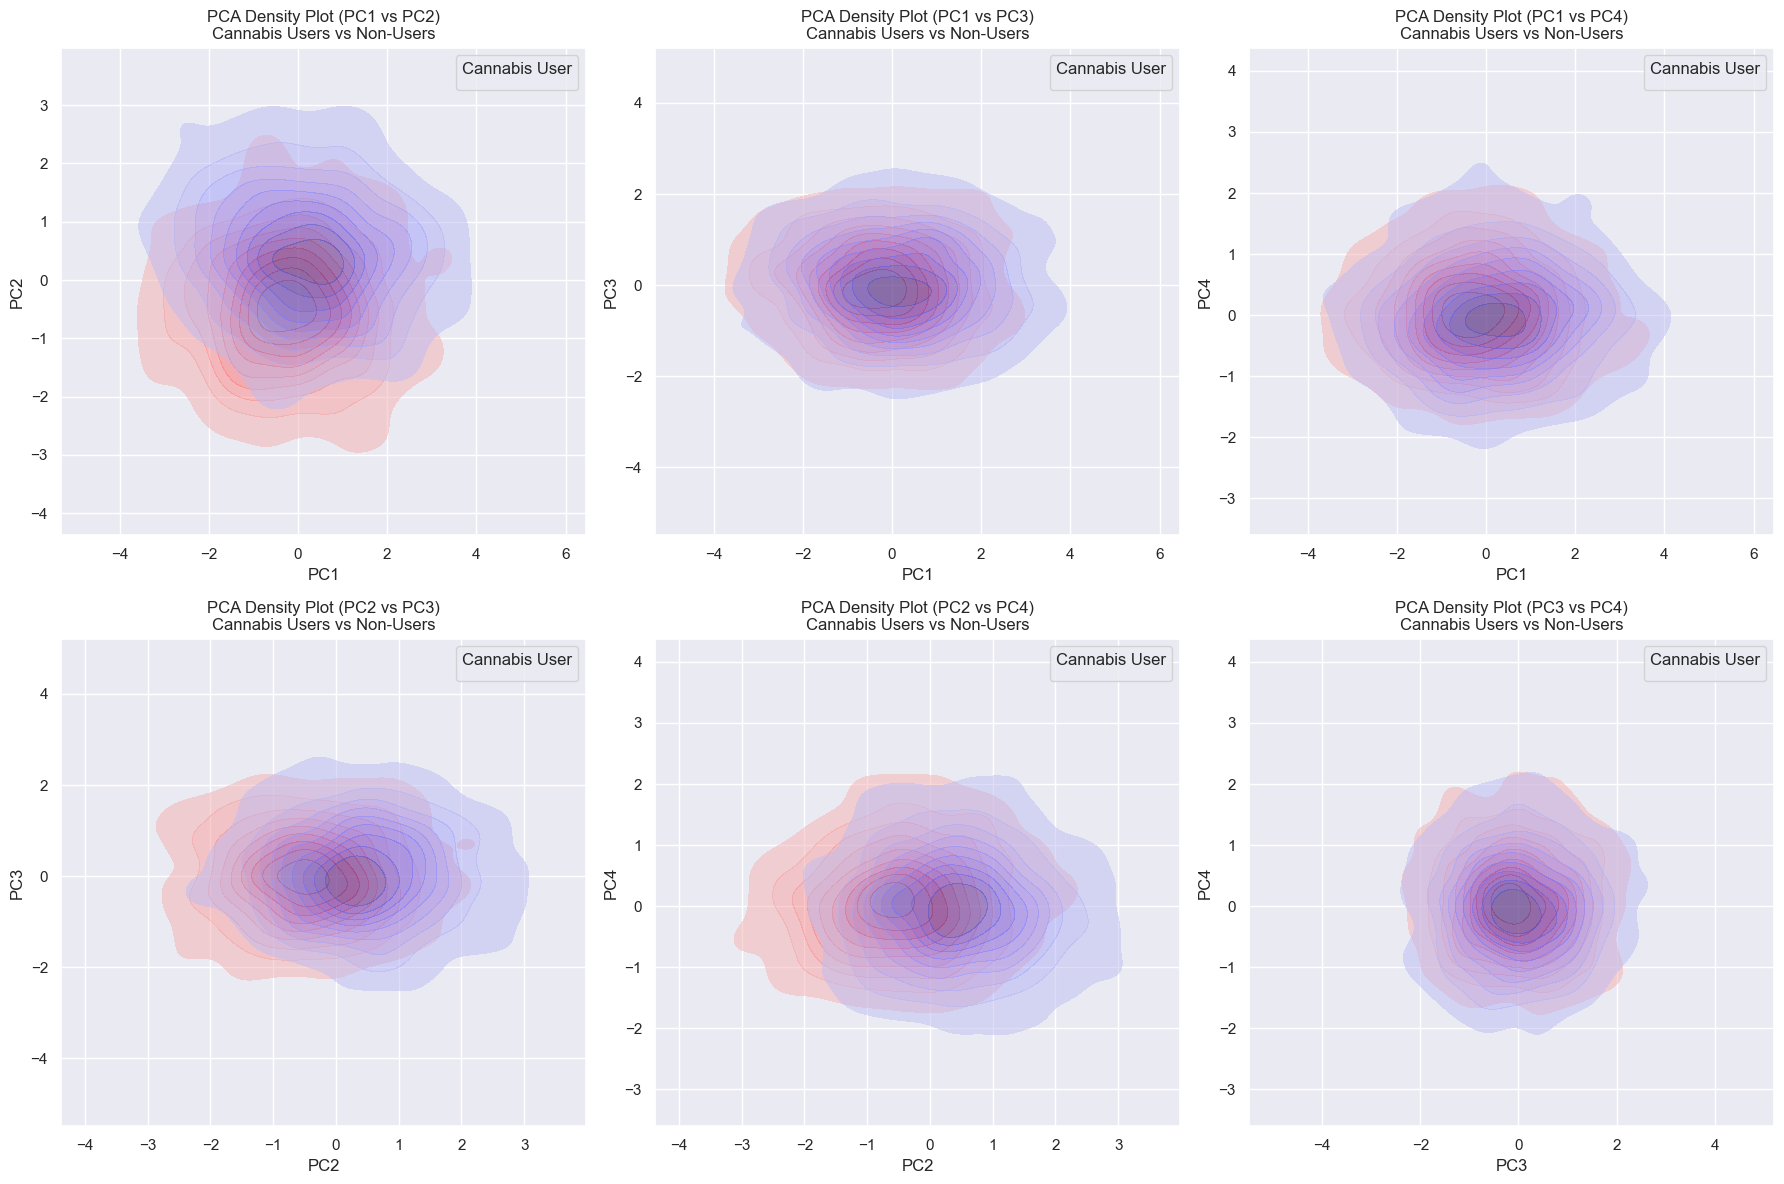

In [ ]:
#plotting the pca
def plot_cannabis_pca(X, y):
    pca, scores = run_pca_and_plot(X, y, "cannabis", "Cannabis")

    # Heatmap
    plt.figure(figsize=(8, 6))
    loadings = pd.DataFrame(pca.components_.T, 
                           columns=[f"PC{i+1}" for i in range(5)], 
                           index=["nscore", "escore", "oscore", "ascore", "cscore"])
    sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title("PCA Components")
    plt.show()

    # Explained variance
    plt.figure(figsize=(8, 6))
    variance_ratio = pca.explained_variance_ratio_
    plt.bar(range(1, 6), variance_ratio, color='skyblue', alpha=0.7)
    plt.plot(range(1, 6), variance_ratio, 'ro-')
    plt.title("Individual Explained Variance Ratio")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Ratio")
    for i, v in enumerate(variance_ratio):
        plt.text(i+1, v+0.01, f'{v:.3f}', ha='center')
    plt.show()

    # Cumulative variance
    plt.figure(figsize=(8, 6))
    cumulative_variance = np.cumsum(variance_ratio)
    plt.plot(range(1, 6), cumulative_variance, 'go-', linewidth=2)
    plt.fill_between(range(1, 6), cumulative_variance, alpha=0.3, color='green')
    plt.ylim(0, 1.05)
    plt.title("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")
    for i, v in enumerate(cumulative_variance):
        plt.text(i+1, v+0.02, f'{v:.3f}', ha='center')
    plt.show()

    # Scatter plots - all PC combinations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    pc_combinations = [("PC1", "PC2"), ("PC1", "PC3"), ("PC1", "PC4"),
                       ("PC2", "PC3"), ("PC2", "PC4"), ("PC3", "PC4")]
    
    for idx, (pc_x, pc_y) in enumerate(pc_combinations):
        sns.scatterplot(data=scores, x=pc_x, y=pc_y, hue="target", 
                        palette={0: "red", 1: "blue"}, alpha=0.6, ax=axes[idx])
        axes[idx].set_title(f"PCA Scatter Plot ({pc_x} vs {pc_y})\nCannabis Users vs Non-Users")
        axes[idx].legend(title="Cannabis User", labels=["Non-user", "User"])
    
    plt.tight_layout()
    plt.show()

    # Density plots - all PC combinations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (pc_x, pc_y) in enumerate(pc_combinations):
        sns.kdeplot(data=scores, x=pc_x, y=pc_y, hue="target", 
                    fill=True, alpha=0.5, thresh=0.05, 
                    palette={0: "red", 1: "blue"}, ax=axes[idx])
        axes[idx].set_title(f"PCA Density Plot ({pc_x} vs {pc_y})\nCannabis Users vs Non-Users")
        axes[idx].legend(title="Cannabis User", labels=["Non-user", "User"])
    
    plt.tight_layout()
    plt.show()

#run
plot_cannabis_pca(X_encoded, y)